## Simple $\Delta G'^\circ$ calculations

In [1]:
%matplotlib inline
from equilibrator_api import ComponentContribution, Reaction, ccache, Q_, ureg
ureg.default_format = '.1f'

reaction = Reaction.parse_formula("kegg:C00002 + kegg:C00001 = kegg:C00008 + kegg:C00009")
cc = ComponentContribution(p_h=Q_(7.0), ionic_strength=Q_("0.25M"), temperature=Q_("298.15K"))

print(reaction)
dG0_prime, uncertainty = cc.standard_dg_prime(reaction)
print(f"ΔG'° = {dG0_prime} ± {1.96*uncertainty}")

dGm_prime, uncertainty = cc.physiological_dg_prime(reaction)
print(f"ΔG'm = {dGm_prime} ± {1.96*uncertainty}")

concentrations = [('kegg:C00002', 1.0),
                  ('kegg:C00009', 0.1),
                  ('kegg:C00008', 3.0)]
for cid, conc in concentrations:
    compound = ccache.get_compound(cid)
    abundance = Q_(conc, "mM")
    reaction.set_abundance(compound, abundance)

dG_prime, uncertainty = cc.dg_prime(reaction)
print(f"ΔG' = {dG_prime} ± {1.96*uncertainty}")

MNXM2 + MNXM3 = MNXM7 + MNXM9
ΔG'° = -25.8 kilojoule / mole ± 0.6 kilojoule / mole
ΔG'm = -42.9 kilojoule / mole ± 0.6 kilojoule / mole
ΔG' = -45.9 kilojoule / mole ± 0.6 kilojoule / mole


## Max-min Driving Force (MDF) example

In [2]:
from equilibrator_api import Reaction, Pathway, Bounds, ComponentContribution, R, Q_
from numpy import ones

p_h = Q_("7.0")
temperature = Q_("298.15K")
ionic_strength = Q_("0.25M")
reactions = ['kegg:C00092 + kegg:C00006 <=> kegg:C01236 + kegg:C00005',
             'kegg:C01236 + kegg:C00001 <=> kegg:C00345',
             'kegg:C00345 + kegg:C00006 <=> kegg:C00199 + kegg:C00011 + kegg:C00005']
reactions = list(map(Reaction.parse_formula, reactions))
fluxes = ones(3)
bounds = Bounds(default_lb=Q_("100 uM"), default_ub=Q_("10 mM"))
pp = Pathway(reactions, fluxes, bounds=bounds, p_h=p_h, ionic_strength=ionic_strength, temperature=temperature)

mdf_data = pp.calc_mdf()
print('MDF = %s RT' % mdf_data.mdf)
mdf_data.compound_df

MDF = 19.6 kilojoule / mole RT


compound concentration  shadow_price       lower_bound      upper_bound
0    MNXM2     0.0 molar           0.5  100.0 micromolar  10.0 millimolar
1    MNXM5     0.0 molar           0.5  100.0 micromolar  10.0 millimolar
2    MNXM6     0.0 molar          -0.5  100.0 micromolar  10.0 millimolar
3   MNXM13     0.0 molar           0.0  100.0 micromolar  10.0 millimolar
4  MNXM145     0.0 molar           0.0  100.0 micromolar  10.0 millimolar
5  MNXM160     0.0 molar           0.5  100.0 micromolar  10.0 millimolar
6  MNXM325     0.0 molar          -0.5  100.0 micromolar  10.0 millimolar
7  MNXM429     0.0 molar           0.0  100.0 micromolar  10.0 millimolar

/home/noore/virtualenvironment/equilibrator/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


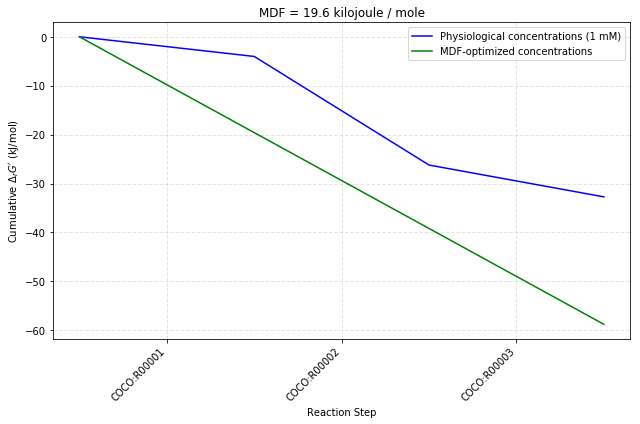

In [3]:
fig1 = mdf_data.reaction_plot
fig1.show()

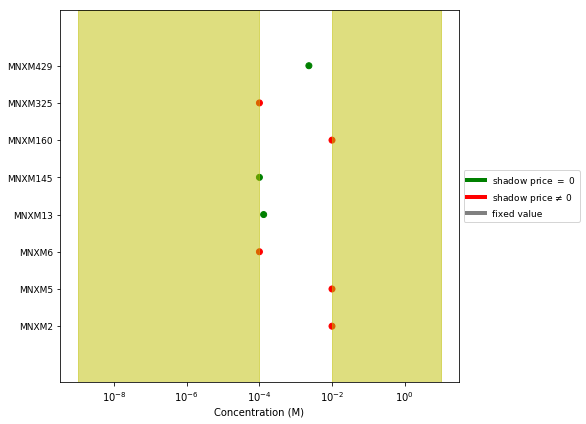

In [4]:
fig2 = mdf_data.compound_plot
fig2.show()

## Reaction matching and $\Delta G'^\circ$ estimation

The reaction matching code is currently not working, and many of the functions need to be reimplemented
after the transition to the new equilibrator-cache.

```
import argparse
from equilibrator_api.pathway import Pathway
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
%matplotlib inline
```

The ± range represents the 95% confidence interval due to Component Contribution estimation uncertainty

```
reaction_matcher = ReactionMatcher()

def estimate_dG0(plaintext, pH=7.0, I=0.1):
    # parse the reaction
    try:
        reaction = reaction_matcher.match(plaintext)
    except ParseError:
        print('incomplete formula')
        return
    except ValueError as e:
        print(e)
        return

    html = '<p>pH = %.2f, I = %.2f M</br>KEGG reaction: %s</br></p>' % (pH, I, reaction.write_formula())
    
    equilibrator = ComponentContribution(pH=pH, ionic_strength=I)
    
    n_e = reaction.check_half_reaction_balancing()
    if n_e is None:
        html += '<p>ERROR: reaction is not chemically balanced</p>'
    elif n_e == 0:
        dG0_prime, dG0_uncertainty = equilibrator.dG0_prime(reaction)
        html += "<h2>\u0394G\'\u00B0 = %.2f \u00B1 %.2f kJ/mol</h2>" % (dG0_prime, 1.96 * dG0_uncertainty)
        ln_RI = equilibrator.reversibility_index(reaction)
        html += '<p>ln(Reversibility Index) = %.1f</p>' % ln_RI

    else:  # treat as a half-reaction
        E0_prime_mV, E0_uncertainty = equilibrator.E0_prime(reaction)
        html += '<h2>E\'\u00B0 = %.1f \u00B1 %.1f mV</h2>' % (E0_prime_mV, E0_uncertainty)

    w = widgets.HTML(html)
    display(w)
```

```
interact(estimate_dG0,
         plaintext=widgets.Text(value='glucose = fructose', font_size=20),
         pH=widgets.FloatSlider(min=0,max=14,step=0.25,value=7),
         I=widgets.FloatSlider(min=0,max=0.5,step=0.02,value=0.1));
```

The ± range represents the 95% confidence interval due to Component Contribution estimation uncertainty

## Single metabolite search

```
compound_matcher = CompoundMatcher()
df = compound_matcher.compound_df

df[df.CID == 'C00031']

def get_closest_matches(plaintext):
    # find matching compound names
    matches = compound_matcher.match(plaintext)
    
    print(matches)
    

get_closest_matches('beta-D-glucose')

matches = compound_matcher.match('beta-D-glucose')


matches.sort_values('score')
```